## Import libraries

In [2]:
import gym
import numpy as np
import random
import math
from time import sleep
from IPython import display
%matplotlib inline
import matplotlib.pyplot as plt


env = gym.make('CartPole-v0')

low = env.observation_space.low
high=env.observation_space.high

input_dim  = env.observation_space.shape[0]
output_dim = env.action_space.n

discount_factor = 0.99 

### Import Keras and define the neural network

In policy gradient, the neural network outputs a softmax probability distribution for each action available, i.e. $\pi_{\theta}(a|s)$ where $\theta$ represents the weights of the neural network.
Remember that the cost function for policy gradient is the expected return over a trajectory $\tau$:
$$ \bar{R}=\sum_{\tau} P_{\theta}(\tau) R(\tau) $$
where $P_{\theta}(\tau$ is the probability of a certain trajectory and $R(\tau)$ is the associated cumulative reward for that particular trajectory.
Policy gradient theorem states that if we update the weights of the neural direction following:
$$ \Delta \theta= \eta \frac{\partial \bar{R} }{\partial \theta} $$
where:
$$ \frac{\partial \bar{R} }{\partial \theta} = \sum_t \mathbb{E} \left[ R \frac{\partial \ln \pi_{\theta} (a_t|s_t)}{\partial \theta}\right]$$ 
<br><br>
To implement all of this in Keras, we can use the "categorial cross-entropy trick":
<img src="http://wwwuser.gwdg.de/~lsarra/ml4p/04/images\policy_gradient_trick.png" alt="Drawing" style="width: 1000px;"/>
<br><br>
Basically, for the training, we need all the state of an episode and the cumulative rewards **starting** from the state onwards, $G_t$:
$$G_t=\sum_{t'=t}\gamma^{t'} r_{t'}$$
Then, the corresponding label for each timestep t:
$$ x[t]=s_t$$
<br>
$$ y[t]=\begin{cases} G_t & \mbox{for each action taken at time }t \\ 0 & \mbox{for every other action}\end{cases}$$

With this choice, the cost function $C=-\sum_a P(a) \ln \pi_{\theta} (a|s)$ becomes:
$$C=- G_t \ln \pi_{\theta} (a_t|s_t) $$
which reproduces the right policy gradient update rule.

In [3]:
import keras as K

model = K.Sequential()
model.add(K.layers.Dense(64, input_dim=input_dim, activation='relu'))
model.add(K.layers.Dense(32, activation='relu'))
model.add(K.layers.Dense(output_dim, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer=K.optimizers.Adam())

Using TensorFlow backend.


You need to define a neural network with two hidden layers of respectively 64 and 32 neurons, while the last layer must have a _softmax_ activation function.

## Policy gradient algorithm

You only need to compute the discounted_rewards list, which contains all the discounted cumulative rewards ($G_t$) of an episode for each timestep. <br>
**Example** discounted_rewards=$[..., 1+0.99 \times1+(0.99^2) \times 1, 1+0.99 \times 1, 1]$
<br>
**Note** To reverse a list, you can simply do list.reverse()

In [4]:
def policy_gradient(states, actions, rewards):
    episode_length = len(states)

    discounted_rewards = []
    discounted_rewards.append(rewards[0])
    for t in range(len(rewards)-1):
        discounted_rewards.append(  pow(discount_factor,t+1)*rewards[t]+discounted_rewards[t]  )
    discounted_rewards.reverse()

    x = np.zeros((episode_length, input_dim))
    y = np.zeros((episode_length, output_dim))

    for i in range(episode_length):
        x[i] = states[i]
        y[i][actions[i]] = discounted_rewards[i]

    model.fit(x, y, epochs=1, verbose=0)

## Rule for selecting an action

_np.random.choice()_ is a useful function to choose among different options, according to a probability distribution $p$.

In [5]:
def select_action(state):
    policy = model.predict(state.reshape(1,input_dim)).flatten()
    return np.random.choice(output_dim, 1, p=policy)[0]

## Simulation

In [6]:
max_episodes = 1000
max_t = 250
combo_goal = 100
timesteps_goal= 195

combo = 0
R=[]


for episode in range(max_episodes):
    all_states, all_actions, all_rewards = [], [], []   
    state = env.reset()
    cumulative_reward = 0 
    for t in range(max_t):    
        action = select_action(state)
        next_state, reward, done, info = env.step(action)
        if done:
            if (t >= 150): 
                combo += 1
            else: 
                combo = 0
            next_state = None            
        cumulative_reward += reward    
        all_states.append(state); all_actions.append(action); all_rewards.append(reward)
        state = next_state
        if done:
            policy_gradient(all_states, all_actions, all_rewards)
            break
            
    print('Episode: {}'.format(episode), 'Total reward: {}'.format(cumulative_reward))
    R.append(cumulative_reward)
    if combo > combo_goal:
        break

Episode: 0 Total reward: 9.0
Episode: 1 Total reward: 22.0
Episode: 2 Total reward: 11.0
Episode: 3 Total reward: 18.0
Episode: 4 Total reward: 34.0
Episode: 5 Total reward: 21.0
Episode: 6 Total reward: 11.0
Episode: 7 Total reward: 11.0
Episode: 8 Total reward: 13.0
Episode: 9 Total reward: 11.0
Episode: 10 Total reward: 10.0
Episode: 11 Total reward: 26.0
Episode: 12 Total reward: 15.0
Episode: 13 Total reward: 17.0
Episode: 14 Total reward: 14.0
Episode: 15 Total reward: 15.0
Episode: 16 Total reward: 11.0
Episode: 17 Total reward: 12.0
Episode: 18 Total reward: 11.0
Episode: 19 Total reward: 13.0
Episode: 20 Total reward: 19.0
Episode: 21 Total reward: 23.0
Episode: 22 Total reward: 18.0
Episode: 23 Total reward: 9.0
Episode: 24 Total reward: 27.0
Episode: 25 Total reward: 19.0
Episode: 26 Total reward: 21.0
Episode: 27 Total reward: 51.0
Episode: 28 Total reward: 13.0
Episode: 29 Total reward: 16.0
Episode: 30 Total reward: 27.0
Episode: 31 Total reward: 28.0
Episode: 32 Total re

Episode: 260 Total reward: 174.0
Episode: 261 Total reward: 158.0
Episode: 262 Total reward: 39.0
Episode: 263 Total reward: 200.0
Episode: 264 Total reward: 106.0
Episode: 265 Total reward: 87.0
Episode: 266 Total reward: 155.0
Episode: 267 Total reward: 64.0
Episode: 268 Total reward: 149.0
Episode: 269 Total reward: 122.0
Episode: 270 Total reward: 45.0
Episode: 271 Total reward: 85.0
Episode: 272 Total reward: 200.0
Episode: 273 Total reward: 115.0
Episode: 274 Total reward: 184.0
Episode: 275 Total reward: 28.0
Episode: 276 Total reward: 48.0
Episode: 277 Total reward: 151.0
Episode: 278 Total reward: 114.0
Episode: 279 Total reward: 34.0
Episode: 280 Total reward: 177.0
Episode: 281 Total reward: 74.0
Episode: 282 Total reward: 200.0
Episode: 283 Total reward: 200.0
Episode: 284 Total reward: 62.0
Episode: 285 Total reward: 36.0
Episode: 286 Total reward: 112.0
Episode: 287 Total reward: 111.0
Episode: 288 Total reward: 84.0
Episode: 289 Total reward: 110.0
Episode: 290 Total rew

Episode: 511 Total reward: 200.0
Episode: 512 Total reward: 200.0
Episode: 513 Total reward: 200.0
Episode: 514 Total reward: 200.0
Episode: 515 Total reward: 200.0
Episode: 516 Total reward: 125.0
Episode: 517 Total reward: 200.0
Episode: 518 Total reward: 200.0
Episode: 519 Total reward: 200.0
Episode: 520 Total reward: 200.0
Episode: 521 Total reward: 200.0
Episode: 522 Total reward: 200.0
Episode: 523 Total reward: 200.0
Episode: 524 Total reward: 200.0
Episode: 525 Total reward: 200.0
Episode: 526 Total reward: 200.0
Episode: 527 Total reward: 200.0
Episode: 528 Total reward: 200.0
Episode: 529 Total reward: 200.0
Episode: 530 Total reward: 200.0
Episode: 531 Total reward: 200.0
Episode: 532 Total reward: 107.0
Episode: 533 Total reward: 200.0
Episode: 534 Total reward: 200.0
Episode: 535 Total reward: 200.0
Episode: 536 Total reward: 200.0
Episode: 537 Total reward: 176.0
Episode: 538 Total reward: 200.0
Episode: 539 Total reward: 184.0
Episode: 540 Total reward: 200.0
Episode: 5

Episode: 761 Total reward: 128.0
Episode: 762 Total reward: 154.0
Episode: 763 Total reward: 113.0
Episode: 764 Total reward: 200.0
Episode: 765 Total reward: 200.0
Episode: 766 Total reward: 200.0
Episode: 767 Total reward: 200.0
Episode: 768 Total reward: 200.0
Episode: 769 Total reward: 200.0
Episode: 770 Total reward: 200.0
Episode: 771 Total reward: 200.0
Episode: 772 Total reward: 200.0
Episode: 773 Total reward: 200.0
Episode: 774 Total reward: 200.0
Episode: 775 Total reward: 200.0
Episode: 776 Total reward: 200.0
Episode: 777 Total reward: 200.0
Episode: 778 Total reward: 200.0
Episode: 779 Total reward: 200.0
Episode: 780 Total reward: 200.0
Episode: 781 Total reward: 200.0
Episode: 782 Total reward: 200.0
Episode: 783 Total reward: 200.0
Episode: 784 Total reward: 200.0
Episode: 785 Total reward: 200.0
Episode: 786 Total reward: 200.0
Episode: 787 Total reward: 200.0
Episode: 788 Total reward: 200.0
Episode: 789 Total reward: 200.0
Episode: 790 Total reward: 200.0
Episode: 7

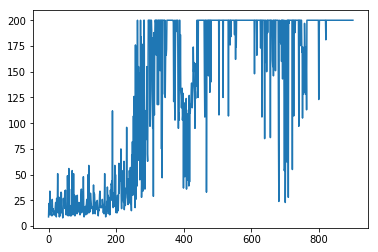

In [7]:
plt.plot(R)
plt.show()

## Bonus

You can see that the training is very noisy, compared to Q-learning.
You can try to implement a baseline:
<img src="http://wwwuser.gwdg.de/~lsarra/ml4p/04/images\baseline.png" alt="Drawing" style="width: 1000px;"/>
Usually a good baseline is an estimate of $G_t$, computed through another neural network. This algorithm is usually called Advantage Actor Critic (or A2C).